# Imports

In [21]:
from __future__ import print_function
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
import torch
import warnings
warnings.filterwarnings('ignore')

In [22]:
# Define device for torch
use_cuda = True
print("CUDA is available:", torch.cuda.is_available())
device = torch.device("cuda" if (use_cuda and torch.cuda.is_available()) else "cpu")

CUDA is available: True


# Load Dataset
WELFake from HuggingFace

In [23]:
from datasets import load_dataset

dataset = load_dataset("lelexuanzz/WELFake_stylo_feats")
print(dataset)

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'has_quotes', 'has_url', 'percent_uppercase', 'frequency_punctuation', 'percent_whitespace', 'frequency_words_length_15', 'frequency_words_length_14', 'frequency_words_length_12', 'frequency_words_length_11', 'avg_sentence_length'],
        num_rows: 70793
    })
})


In [24]:
df = dataset["train"].to_pandas()
print(df)

                                                    text  label  has_quotes  \
0      No comment is expected from Barack Obama Membe...      1           0   
1       Now, most of the demonstrators gathered last ...      1           0   
2      A dozen politically active pastors came here f...      0           0   
3      The RS-28 Sarmat missile, dubbed Satan 2, will...      1           0   
4      All we can say on this one is it s about time ...      1           0   
...                                                  ...    ...         ...   
70788  WASHINGTON (Reuters) - Hackers believed to be ...      0           0   
70789  You know, because in fantasyland Republicans n...      1           0   
70790  Migrants Refuse To Leave Train At Refugee Camp...      0           1   
70791  MEXICO CITY (Reuters) - Donald Trump’s combati...      0           0   
70792  Goldman Sachs Endorses Hillary Clinton For Pre...      1           0   

       has_url  percent_uppercase  frequency_punctu

In [25]:
from sklearn.model_selection import train_test_split

seed = 45

y = df["label"]
x = df.drop(labels=["label","text"], axis=1)

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=seed)

print(x_train, y_train)

       has_quotes  has_url  percent_uppercase  frequency_punctuation  \
33090           0        0           4.365983                     42   
13814           0        1           2.970607                     70   
47609           0        0           3.880804                     29   
30722           0        0           3.251016                     67   
1945            0        1           2.789491                     77   
...           ...      ...                ...                    ...   
12895           0        1           3.202995                     61   
60960           0        1           2.864939                     32   
6012            0        1          17.731959                     11   
63107           0        0           3.806452                     30   
6558            0        0           5.263158                      4   

       percent_whitespace  frequency_words_length_15  \
33090           16.362946                          0   
13814           16.8230

### Training

In [26]:
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import pandas as pd

In [27]:
lr_model = LogisticRegression(C=1.0, random_state=42, max_iter=1000)
lr_model.fit(x_train, y_train)

LogisticRegression(max_iter=1000, random_state=42)

In [28]:
y_pred = lr_model.predict(x_test)

In [29]:

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: ", accuracy)

Accuracy:  0.6660074864044071


In [30]:
import json
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: ", accuracy)
report = classification_report(y_test, y_pred, target_names=['Real', 'Fake'], output_dict=True)
metrics = {"accuracy": accuracy, "classification_report": report}
with open('./logs/lr_beforetuning_metrics.json', 'w') as f:
    json.dump(metrics, f, indent=4)


Classification Report:
              precision    recall  f1-score   support

           0       0.69      0.58      0.63      7006
           1       0.65      0.75      0.69      7153

    accuracy                           0.67     14159
   macro avg       0.67      0.67      0.66     14159
weighted avg       0.67      0.67      0.66     14159

Accuracy:  0.6660074864044071


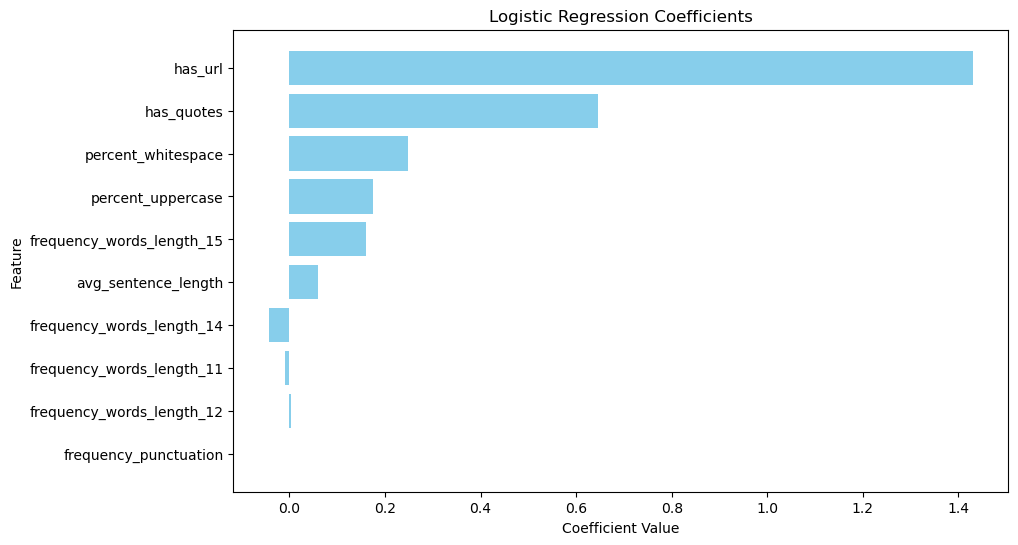

In [31]:
import pandas as pd
import matplotlib.pyplot as plt

# Extract coefficients and feature names
coefficients = lr_model.coef_[0]
features = x_train.columns

# Create a DataFrame for better visualization
coef_df = pd.DataFrame({'Feature': features, 'Coefficient': coefficients})

# Sort by absolute value of coefficients
coef_df = coef_df.reindex(coef_df['Coefficient'].abs().sort_values(ascending=False).index)

# Plot the coefficients
plt.figure(figsize=(10, 6))
plt.barh(coef_df['Feature'], coef_df['Coefficient'], color='skyblue')
plt.xlabel('Coefficient Value')
plt.ylabel('Feature')
plt.title('Logistic Regression Coefficients')
plt.gca().invert_yaxis()  # Invert y-axis for better readability
plt.show()

## Tuning c regularisation parameter

In [32]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score

# Define the parameter grid for C
param_grid = {'C': [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]}

# Set up GridSearchCV
grid_search = GridSearchCV(LogisticRegression(max_iter=1000, random_state=42), 
                           param_grid, 
                           cv=5, 
                           scoring='accuracy')

# Fit the model
grid_search.fit(x_train, y_train)

# Print the best parameters and cross-validation accuracy
print("\nBest parameters found: ", grid_search.best_params_)
print("Best cross-validation accuracy: {:.4f}".format(grid_search.best_score_))

# Evaluate the model with the best parameters
best_lr = grid_search.best_estimator_
y_pred_best = best_lr.predict(x_test)
accuracy_best = accuracy_score(y_test, y_pred_best)
print("Test accuracy with best parameters: {:.4f}".format(accuracy_best))


Best parameters found:  {'C': 1.0}
Best cross-validation accuracy: 0.6633
Test accuracy with best parameters: 0.6660


In [33]:
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: ", accuracy)
report = classification_report(y_test, y_pred, target_names=['Real', 'Fake'], output_dict=True)
metrics = {"accuracy": accuracy, "classification_report": report}
with open('./results/lr_metrics.json', 'w') as f:
    json.dump(metrics, f, indent=4)


Classification Report:
              precision    recall  f1-score   support

           0       0.69      0.58      0.63      7006
           1       0.65      0.75      0.69      7153

    accuracy                           0.67     14159
   macro avg       0.67      0.67      0.66     14159
weighted avg       0.67      0.67      0.66     14159

Accuracy:  0.6660074864044071


In [34]:
import joblib

joblib.dump(lr_model, './models/lr_model.pkl')
print("Model saved as lr_model.pkl")

Model saved as lr_model.pkl
